# 📥 Importation des données

In [158]:
import numpy as np              # Pour les vecteurs et les matrices
import matplotlib.pyplot as plt # Pour les graphiques
import pandas as pd             
import sklearn as sk 
import re                       # Expression régulière
from enum import Enum

acousticness = 0
artists = 1
danceability = 2
duration_ms = 3
energy = 4
explicit = 5
identifier = 6
instrumentalness = 7
key = 8
liveness = 9
loudness = 10
mode = 11
name = 12
popularity = 13
release_date = 14
speechiness = 15
tempo = 16
valence = 17
year = 18

# Enumerations des notes
class Key_Type(Enum):
    C = 0
    C_Sharp = 1
    D = 2
    D_Sharp = 3
    E = 4
    F = 5
    F_Sharp = 6
    G = 7
    G_Sharp = 8
    A = 9
    A_Sharp = 10
    B = 11

Data = pd.read_csv("data.csv", header=None)

n, p = Data.shape

print(f"Le jeu de donnée contient {p} variables pour {n} observations")

Le jeu de donnée contient 19 variables pour 169909 observations


| Index | Nom | Type | Exemple | Description |
| -- | --- | --- | --- | --- |
| 0 | `acousticness` | Quantitative continue | | Une mesure de confiance de 0,0 à 1,0 pour déterminer si la piste est acoustique, c'est à dire quelle ne contient pas d'instruments de musiques électroniques. 1,0 représente une confiance élevée dans le fait que la piste est acoustique. |
| 1 | `artists` | tableau de chaînes de caractères | `["Michael Jackson", "Paul McCartney"]`  | Tableau contenant tous les artistes. |
| 2 | `danceability` | Quantitative continue | `0.56` | L'aptitude à la danse décrit dans quelle mesure un morceau se prête à la danse. Une valeur de 0,0 est la moins dansante et une valeur de 1,0 est la plus dansante. |
| 3 | `duration_ms` | Quantitative ponctuelle | `240000` pour une musique de 240 secondes (4 minutes)  | La durée de la piste en millisecondes. |
| 4 | `energy` | Quantitative continue | `0.84` | L'énergie est une mesure comprise entre 0,0 et 1,0 et représente une mesure perceptuelle de l'intensité et de l'activité. En règle générale, les morceaux énergiques sont rapides, forts et bruyants. Par exemple, le death metal a une énergie élevée, tandis qu'un prélude de Bach obtient un score faible sur l'échelle. Les caractéristiques perceptives contribuant à cet attribut comprennent la gamme dynamique, l'intensité sonore perçue, le timbre, la vitesse d'apparition et l'entropie générale.|
| 5 | `explicit` | booléen | `True` une musique explicite | Indique si la musique est explicite (destinée à un public adulte) ou non. |
| 6 | `id` | chaîne de caractères |  | Identifiant spotify de la musique. |
| 7 | `instrumentalness` | Quantitative continue | | Détermine si une piste ne contient pas de voix. Les sons "Ooh" et "aah" sont considérés comme instrumentaux dans ce contexte. Les morceaux de rap ou de musique parlée sont clairement "vocaux". Plus la valeur de l'instrumentalité est proche de 1,0, plus il est probable que la piste ne contienne pas de contenu vocal. Les valeurs supérieures à 0,5 sont censées représenter des pistes instrumentales, mais la confiance est d'autant plus grande que la valeur s'approche de 1,0. |
| 8 | `key` | Qualitative | `3` pour Ré# | La tonalité de la piste. Les nombres entiers correspondent aux hauteurs en utilisant la notation standard de la classe de hauteur. Si aucune clé n'a été détectée, la valeur est -1. |
| 9 | `liveness` | Quantitative continue | `0.9` | Détecte la présence d'un public dans l'enregistrement. Des valeurs de vivacité plus élevées représentent une probabilité accrue que la piste ait été jouée en direct. Une valeur supérieure à 0,8 indique une forte probabilité que la piste soit en direct. |
| 10 | `loudness` | Quantitative continue | | L'intensité sonore globale d'une piste en décibels (dB). Les valeurs d'intensité sonore sont calculées en moyenne sur l'ensemble de la piste et sont utiles pour comparer l'intensité sonore relative des pistes. L'intensité sonore est la qualité d'un son qui est le principal corrélat psychologique de la force physique (amplitude). Les valeurs se situent généralement entre -60 et 0 db.|
| 11 | `mode` | Quantitative ponctuelle | `True` pour une musique en gamme majeure. | Mode indique la modulation (majeure ou mineure) d'une piste. Une piste modulée dans la gamme mineure sonne plus sombre que celle modulée dans la gamme majeure. |
| 12 | `name` | chaîne de caractères | `"S&M"`| Nom du titre. |
| 13 | `popularity` | Quantitative ponctuelle | |
| 14 | `release_date` | chaîne de caractères | `2003-04-15` | Date de sortie de la musique au format `AAAA-MM-JJ`. |
| 15 | `speechiness` | Quantitative continue | | Représente la présence de mots parlés dans une piste. Plus l'enregistrement est exclusivement vocal (par exemple, talk-show, livre audio, poésie), plus la valeur de l'attribut est proche de 1,0. Les valeurs supérieures à 0,66 décrivent des pistes qui sont probablement composées exclusivement de paroles. Les valeurs comprises entre 0,33 et 0,66 décrivent des pistes qui peuvent contenir à la fois de la musique et de la parole, soit en sections, soit en couches, y compris des cas tels que la musique rap. Les valeurs inférieures à 0,33 représentent très probablement de la musique et d'autres pistes ne ressemblant pas à de la parole. |
| 16 | `tempo` | Quantitative continue | | Le tempo global estimé d'une piste en battements par minute (BPM). Dans la terminologie musicale, le tempo est la vitesse ou le rythme d'un morceau donné et découle directement de la durée moyenne des battements. |
| 17 | `valence` | Quantitative continue | | Une mesure de 0,0 à 1,0 décrivant la positivité musicale transmise par une piste. Les morceaux ayant une valence élevée sonnent plus positivement (par exemple, heureux, gai, euphorique), tandis que les morceaux ayant une valence faible sonnent plus négativement (par exemple, triste, déprimé, en colère). |
| 18 | `year` | Quantitative ponctuelle | `2021` | L'année de sortie de la piste. |

Afin de déterminer la dansabilité d'une musique par rapport à ses caractéristiques, nous allons donc effectuer des analyses des variables suivantes en fonction de la variable `danceability`.

- 

Dans notre analyse nous ignorons totalement les variables suivantes

- `release_date` : car elle est redondante avec l'année de sortie (`year`) de la musique.
- `id` : cela n'a pas d'intérêt pour l'analyse.

In [159]:
Quantitatives_Variables = [ Data[acousticness], 
                            Data[duration_ms], 
                            Data[energy], 
                            Data[instrumentalness],
                            Data[key],
                            Data[liveness], 
                            Data[loudness], 
                            Data[mode],
                            Data[popularity],
                            Data[speechiness],
                            Data[tempo],
                            Data[valence],
                            Data[year]]

Quantitatives_Variables = np.array(Quantitatives_Variables).T

Danceability = np.array(Data[danceability]).T

p_2 = len(Quantitatives_Variables)

print(f"Le jeu de donné contient {p_2} variables pour {n} observations.")

Le jeu de donné contient 169909 variables pour 169909 observations.


Les variables qui nous intéressent

# 📊 Représentations graphiques

## 🔤 Variables qualitatives

### 👨‍🎤 Artiste

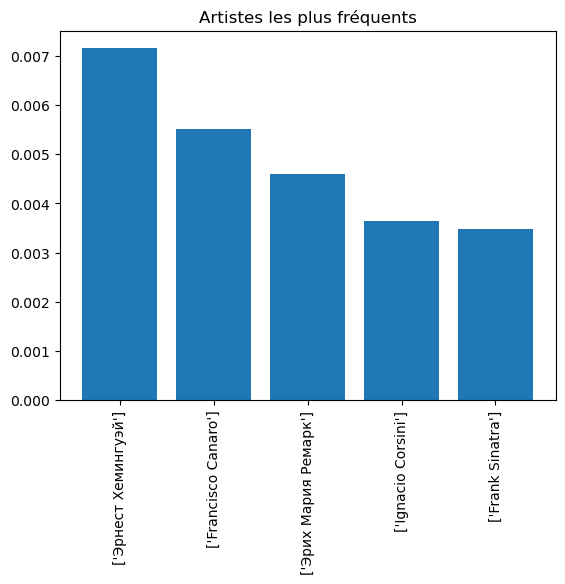

In [160]:
Artists_Unique, Artistes_Frequency = np.unique(Data[artists], return_counts=True)

Artists_Unique = Artists_Unique[Artistes_Frequency.argsort()]
Artistes_Frequency = Artistes_Frequency[Artistes_Frequency.argsort()] / n

Artists_Unique = Artists_Unique[::-1]
Artistes_Frequency = Artistes_Frequency[::-1]

plt.bar(Artists_Unique[:5], Artistes_Frequency[:5])
plt.title("Artistes les plus fréquents")
plt.xticks(rotation='vertical')
plt.savefig("./Images/Artistes les plus fréquents.svg")
plt.show()

Il n'y a pas grand chose à déduire, cependant on peut remarquer que les artistes les plus représentés sont les artistes qui ont le plus de musiques dans le dataset. On peut aussi remarquer que les artistes les plus représentés sont des artistes qui ont commencé leur carrière dans les années 60-70.

## 🔢 Variables quantitatives

### Variables ponctuelles

#### 🕰️ Année

On ignore la variable `release_date` car elle est redondante avec la variable `year`. 

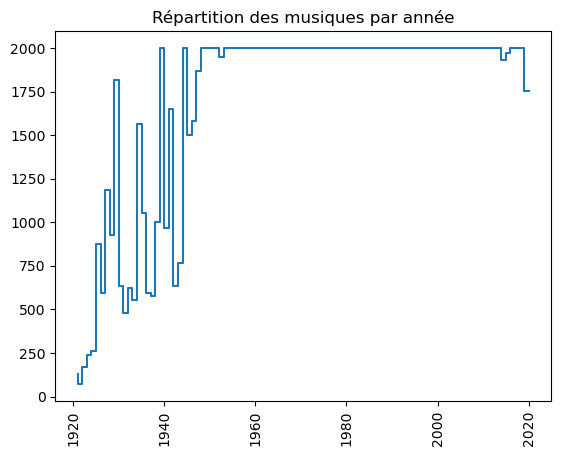

In [161]:
Release_Date_Year_Unique, Release_Date_Count = np.unique(Data[year], return_counts=True)

plt.step(Release_Date_Year_Unique, Release_Date_Count)
plt.title("Répartition des musiques par année")
plt.xticks(rotation='vertical')
plt.savefig("./Images/Répartition des musiques par année.svg")
plt.show()


On constate que les années sont représentées de manière uniforme dans ce jeu de données à partir de 1950 (2000 par année). Ce qui est logique afin d'avoir la représentation la plus objective possible. Le manque de musique avant 1950 est dû au fait que les musiques de cette époque ne sont pas assez représentées dans les plateformes de streaming (perte de données liée à la guerre ?).

#### 🅴 Explicite

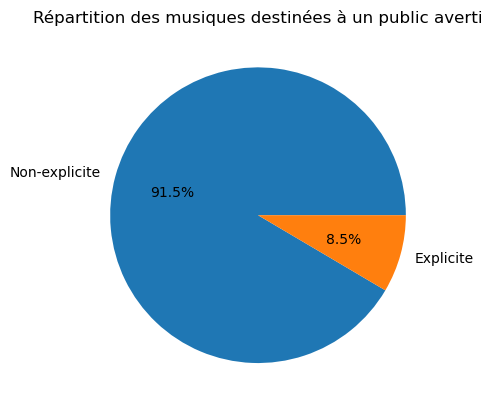

In [162]:
Explicit_Unique, Explicit_Count = np.unique(Data[explicit], return_counts=True)

Explicit_Count = Explicit_Count / n

plt.pie(Explicit_Count, labels=["Non-explicite", "Explicite"], autopct='%1.1f%%')
plt.title("Répartition des musiques destinées à un public averti")
plt.savefig("./Images/Répartition des musiques destinées à un public averti.svg")
plt.show()

On remarque que la majorité des musiques ne sont pas explicites.

### 🎼 Tonalité

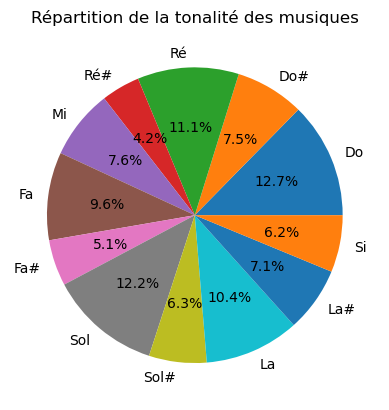

In [163]:
Key_Unique, Key_Count = np.unique(Data[key], return_counts=True)

plt.pie(Key_Count, labels=["Do", "Do#", "Ré", "Ré#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"], autopct='%1.1f%%')
plt.title("Répartition de la tonalité des musiques")
plt.savefig("./Images/Répartition de la tonalité des musiques.svg")
plt.show()


### 📈 Variables continues

-  `acousticness`
-  `danceability`
-  `duration_ms`
-  `energy`
-  `instrumentalness`
-  `liveness`
-  `loudness`
-  `speechiness`
-  `valence`

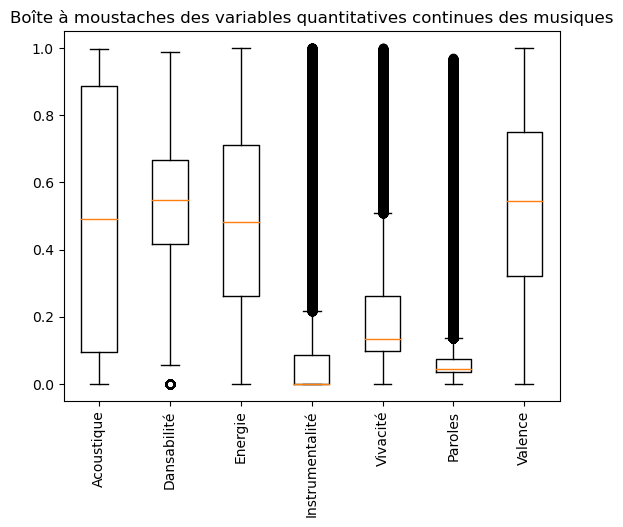

In [164]:
Boxplot_Data = [Data[acousticness], Data[danceability], Data[energy], Data[instrumentalness], Data[liveness], Data[speechiness], Data[valence]]

plt.boxplot(Boxplot_Data)
plt.title("Boîte à moustaches des variables quantitatives continues des musiques")
plt.xticks([1, 2, 3, 4, 5, 6, 7], ["Acoustique", "Dansabilité", "Energie", "Instrumentalité", "Vivacité", "Paroles", "Valence"], rotation='vertical')
plt.savefig("./Images/Boîte à moustaches des caractéristiques continues des musiques.svg")
plt.show()

On se rend compte
Les bars noirs correspondent aux points (bcp trop)

# 🔬 Analyse

## Analyse en Composantes Principales

Tout d'abord, on normalise les données pour que les variables soient comparables.

In [165]:
Mean = np.mean(Quantitatives_Variables, axis=0)

Standard_Deviation = np.std(Quantitatives_Variables, axis=0)

print(Mean.shape)
print(Standard_Deviation.shape)

(13,)
(13,)


(169909, 13)
(13,)
(13,)


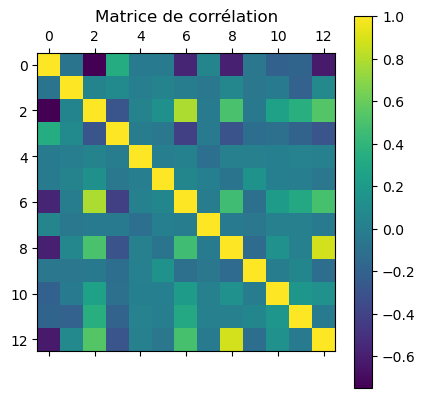

In [166]:
print(Quantitatives_Variables.shape)
print(Mean.shape)
print(Standard_Deviation.shape)

Data_Normalized = (Quantitatives_Variables - Mean) / Standard_Deviation

Data_Normalized.shape

Correlation_Matrix = (Data_Normalized.T @ Data_Normalized) / n

Eighenvalues, Eighenvectors = np.linalg.eigh(Correlation_Matrix)

plt.matshow(Correlation_Matrix)
plt.colorbar()
plt.title("Matrice de corrélation")
plt.savefig("./Images/Matrice de corrélation.svg")
plt.show()

La matrice a bien une diagonale dominante, ce qui est normal car les variables sont indépendantes. On peut donc appliquer l'ACP.

## Régressions linéaires multiples

In [167]:
n, p = Quantitatives_Variables.shape

print(Quantitatives_Variables.shape)

Linear_Regressions = np.concatenate((Quantitatives_Variables, np.ones((n, 1))), axis=1)

print(Linear_Regressions)
print(Linear_Regressions.shape)

(169909, 13)
[[9.95000e-01 1.58648e+05 1.95000e-01 ... 7.79000e-01 1.92800e+03
  1.00000e+00]
 [9.94000e-01 2.82133e+05 1.35000e-02 ... 7.67000e-02 1.92800e+03
  1.00000e+00]
 [6.04000e-01 1.04300e+05 2.20000e-01 ... 8.80000e-01 1.92800e+03
  1.00000e+00]
 ...
 [5.38000e-01 1.80700e+05 5.39000e-01 ... 1.53000e-01 2.02000e+03
  1.00000e+00]
 [7.14000e-02 1.67308e+05 7.61000e-01 ... 4.72000e-01 2.02000e+03
  1.00000e+00]
 [1.09000e-01 2.14787e+05 4.28000e-01 ... 3.66000e-01 2.02000e+03
  1.00000e+00]]
(169909, 14)


13
(14,)


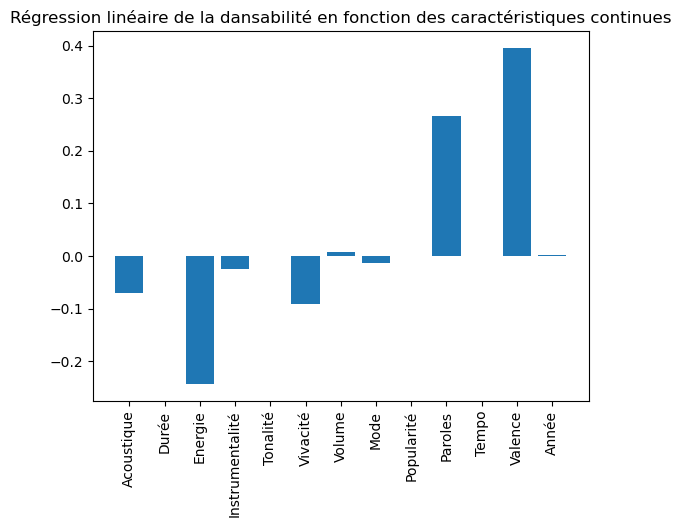

In [168]:
Alpha = np.linalg.solve(Linear_Regressions.T @ Linear_Regressions, Linear_Regressions.T @ Danceability)
print(p)
print(Alpha.shape)

plt.bar(np.arange(p), Alpha[:-1])
plt.title("Régression linéaire de la dansabilité en fonction des caractéristiques continues")
plt.xticks(np.arange(p), ["Acoustique", "Durée", "Energie", "Instrumentalité", "Tonalité", "Vivacité", "Volume", "Mode", "Popularité", "Paroles", "Tempo", "Valence", "Année"], rotation='vertical')
plt.savefig("./Images/Régression linéaire de la dansabilité en fonction des caractéristiques continues.svg")
plt.show()

On se rend alors compte compte que les variables favorisant le plus à la danceabilité d'une musique sont :
- `speechiness` : La quantité de paroles dans la musique
- `valence` : La positivité de la musique

Tandis que les variables qui défavorisent le moins la danceabilité d'une musique sont :

- `acousticness` : La quantité d'instruments acoustiques dans la musique
- `energy` : L'énergie de la musique
- `liveness` : La présence d'un public dans la musique

Les autres variables ne semblent pas contribuer de manière significative à la danceabilité d'une musique.

Ces résultats sont cohérents avec les résultats de l'ACP, mais également sembler aller vers le sens commun (excepté l'énergie de la musique, mais cette de la musique est subjective).

In [169]:
Z = Linear_Regressions @ Alpha

Errors = abs(Z - Danceability)
print(f"La moyenne des valeurs absolues des résidus est de : {np.mean(Errors)}")

SCT = np.sum((Danceability - np.mean(Danceability))**2)
SCE = np.sum(Errors**2)

Correlation_Coefficient = 1 - (SCE / SCT)
Correlation_Coefficient = np.corrcoef(Z, Danceability)[0, 1]

print(f"Le coefficient de correlation R² est de {Correlation_Coefficient} (nice 😏)")

s2  = np.sum(Errors ** 2) / (n - 2)

print(f"La variance des résidus est de {s2}")

La moyenne des valeurs absolues des résidus est de : 0.10005411591569972
Le coefficient de correlation R² est de 0.6989325507948758 (nice 😏)
La variance des résidus est de 0.01572653852396768


## Test statistiques 

Que fait-on ?

## Complémentaire

Dans cette partie, nous allons essayer d'analyser d'autres variables qui ne sont pas directement concerné par notre sujet, mais qui peuvent apporter des informations complémentaires concernant

### Explicite et popularité

### Explicite et année

In [170]:

# Explicit_Data = []
# 
# for Y in Release_Date_Year_Unique:
#     Number_Explicit = 0
#     for i in range(len(Data[year])):
#         if (Data[year][i] == Y) and (Data[explicit][i] == True):
#             Number_Explicit += 1
#     Explicit_Data.append([Y, i])
# 
# 
# print(Explicit_Data)

# Application

Bien que cet exemple n'ai pas énormément d'intéret, cela nous permet de tester l'efficacité de notre modèle. En effet, nous allons essayer de prédire la dansabilité d'une musique en fonction de ses caractéristiques fournies par l'API Spotify. Comme l'API de Spotify fourni également des informations sur la dansabilité, nous allons pouvoir comparer nos résultats avec ceux de l'API.

In [192]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os

Client_ID = "a757131d2d114c91b4a01f4845441f89"      # ! : Identifiants privés à ne pas partager (provient de mon compte spotify).
Client_Secret = "05a4f6e6955646d7865df73e0c89de2d"  # ! : Identifiants privés à ne pas partager (provient de mon compte spotify).

Enable = True # True pour activer le code

if Enable: # Eviter de lancer le code à chaque fois
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=Client_ID,            
                                                            client_secret=Client_Secret))       

    #Search_Input = input("Quelle musique voulez-vous rechercher ?")
    Search_Input = "Poker Face"

    Results = sp.search(q=Search_Input, limit=10)

    for i, Track in enumerate(Results['tracks']['items']):
        String = str(i) + '\t' + Track['name'] + '\t'

        for j, Artist in enumerate(Track['artists']):
            if j != 0:
                String += " | "
            String += Artist['name']

        print(String)

    #Input = input("Quelle musique voulez-vous selectionner ?")
    Input = 0
    Identifier = Results['tracks']['items'][int(Input)]['id']

    Track = sp.track(Identifier)
    Audio_Features = sp.audio_features(Identifier)[0]
    Audio_Analysis = sp.audio_analysis(Identifier)

    Search_Data = np.array([[
            Audio_Features['acousticness'],
            Audio_Features["duration_ms"],
            Audio_Features['energy'],
            Audio_Features['instrumentalness'],
            Audio_Analysis["sections"][0]["key"],
            Audio_Features['liveness'],
            Audio_Analysis["sections"][0]["loudness"],
            Audio_Analysis["sections"][0]["mode"],
            Track['popularity'],
            Audio_Features['speechiness'],
            Audio_Analysis["sections"][0]["tempo"],
            Audio_Features['valence'],
            int(Track["album"]["release_date"].split("-")[0]),
            1
        ]])

    Search_Danceability = (Search_Data @ Alpha)[0]

    print(f"La dansabilité de \"{Search_Input}\" d'après le modèle est de : {round(Search_Danceability * 100, 2)} %.")
    
    print(f"La musique d'après spotify à une dansabilité de : {Audio_Features['danceability'] * 100} %.")


0	Poker Face	Lady Gaga
1	Poker Face	LUCKI
2	Poker Face	Lady Gaga
3	Poker Face	Lady Gaga
4	Poker Face (Eric Cartman)	UNKZWN
5	Poker Face (sped up) - Remix	Splice Records
6	Poker Face	Lady Gaga
7	Poker Face - LLG vs GLG Radio Mix	Lady Gaga | Guéna LG
8	Poker Face	First to Eleven
9	Poker Face	Jax
La dansabilité de "Poker Face" d'après le modèle est de : 57.39 %.
La musique d'après spotify à une dansabilité de : 85.1 %.
